In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Data/Cleaned_deathCnt/*.csv'
dic_files = Load_files.load_files(path, -14, -12)
data = dic_files['서울']
data['dailyCnt'] = data['defCnt'].diff().fillna(0)
data

,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay,dailyCnt
0,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-20,0.0
1,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-21,0.0
2,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-22,0.0
3,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-23,0.0
4,0,1,서울,Seoul,1.0,0,1,0,1,0.0,2020-01-24,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1214,6471,6162486,서울,Seoul,4329.0,0,0,4371,0,65361.0,2023-05-20,4329.0
1215,6473,6166682,서울,Seoul,4196.0,0,0,4195,1,65406.0,2023-05-21,4196.0
1216,6476,6167953,서울,Seoul,1271.0,0,0,1271,0,65419.0,2023-05-22,1271.0
1217,6477,6173315,서울,Seoul,5362.0,0,0,5359,3,65476.0,2023-05-23,5362.0


In [3]:
learning_rates_list = [1e-3, 1e-4]
patiences_list = [20, 50]
num_layers_list = [1, 2, 4]
batch_sizes_list = [32, 64, 128]
hidden_sizes_list = [8, 16, 32]
dropout_list = [0.25, 0.5]
criterions_list = [nn.MSELoss(), criterion2, criterion3]

hyperparameter_dict = {}
i = 0

for lr in learning_rates_list:
    for patience in patiences_list:
        for num_layers in num_layers_list:
            for batch_sizes in batch_sizes_list:
                for hidden_size in hidden_sizes_list:    
                    for dropout in dropout_list:
                        for criterion in criterions_list:
                            hyperparameter_dict[i] = [lr, patience, num_layers, batch_sizes, hidden_size, dropout, criterion]
                            i += 1
                        
print(i)

648


In [4]:
criterion = nn.MSELoss()

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'stdDay', 'dailyCnt')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

mape_min = np.inf
best_model = {}

for hyperparameter in tqdm(hyperparameter_dict.values(), desc = '서울_seq2seq_RNN', position = 0):
    lr = hyperparameter[0]
    patience = hyperparameter[1]
    num_layers = hyperparameter[2]
    batch_size = hyperparameter[3]
    hidden_size = hyperparameter[4]
    dropout = hyperparameter[5]
    criterion = hyperparameter[6]
    print('----------------------------------------------------------------------------------------------------------')
    print('lr:', lr, ' patience:', patience, ' num_layers:', num_layers, 
          ' batch_size:', batch_size, ' hidden_size:', hidden_size, ' dropout:', dropout, 'criterion:', criterion)
    
    x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 800, 60, 7, batch_size, 'mtm')
    

    model = RNN_encoder_decoder(input_size = input_size,
                                hidden_size = hidden_size,
                                num_layers = num_layers, 
                                dropout = dropout, 
                                device = device).to(device)

    optimizer = Adam(model.parameters(), lr = lr)
    
    loss_list, model, epoch = Trainer.Many_to_Many(train_loader, 
                                                   test_loader, 
                                                   model, 
                                                   criterion, 
                                                   optimizer, 
                                                   num_epochs, 
                                                   patience,
                                                   device)
    
    label_y, predicted, first_label_y, first_predicted = predict_mtm(model, df, x_ss, y_ms, 1151, 7, 0.5, device)
    
    if mape_min > mape(label_y+1, predicted):
        mape_min = mape(label_y+1, predicted)
        best_model['seq2seq_RNN'] = [mape_min, model, loss_list, epoch, lr, patience, 
                                     num_layers, batch_size, hidden_size, dropout, criterion]

서울_seq2seq_RNN:   0%|          | 0/648 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 153 loss: 0.001515
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 165 loss: 0.014420
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 142 loss: 0.003530
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 70 loss: 0.001923
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 178 loss: 0.018744
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 175 loss: 0.003165
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 100 loss: 0.001084
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 92 loss: 0.015591
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 71 loss: 0.003649
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 132 loss: 0.001150
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 98 loss: 0.012645
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 108 loss: 0.003212
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 93 loss: 0.001212
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 89 loss: 0.015609
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 65 loss: 0.003592
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 111 loss: 0.001209
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 91 loss: 0.012922
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 81 loss: 0.003350
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 117 loss: 0.001389
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 236 loss: 0.013048
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 117 loss: 0.002409
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 152 loss: 0.001787
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 122 loss: 0.015916
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 154 loss: 0.002853
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 146 loss: 0.000955
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 129 loss: 0.016587
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 111 loss: 0.002333
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 140 loss: 0.001162
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 140 loss: 0.018600
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 180 loss: 0.002234
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 117 loss: 0.001018
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 134 loss: 0.014947
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 127 loss: 0.003056
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 69 loss: 0.001153
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 154 loss: 0.013677
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 85 loss: 0.002570
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 267 loss: 0.001146
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 202 loss: 0.014196
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 171 loss: 0.002234
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 189 loss: 0.001701
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 290 loss: 0.012776
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.001927
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 202 loss: 0.000777
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 72 loss: 0.014613
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 93 loss: 0.002090
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 281 loss: 0.000798
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 167 loss: 0.012126
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 100 loss: 0.002056
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 176 loss: 0.000569
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 69 loss: 0.012612
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 164 loss: 0.001976
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 92 loss: 0.001060
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 206 loss: 0.010200
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 211 loss: 0.001473
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 171 loss: 0.001747
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 131 loss: 0.017575
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 47 loss: 0.007388
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 148 loss: 0.001984
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 183 loss: 0.029118
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 94 loss: 0.007164
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 68 loss: 0.002101
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 67 loss: 0.014673
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 191 loss: 0.004480
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 186 loss: 0.001399
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 86 loss: 0.022076
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 102 loss: 0.005182
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 133 loss: 0.000791
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 56 loss: 0.016249
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 105 loss: 0.003915
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 192 loss: 0.000830
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 80 loss: 0.024020
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 99 loss: 0.004719
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 254 loss: 0.001430
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 213 loss: 0.025562
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 154 loss: 0.002549
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 233 loss: 0.001584
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 179 loss: 0.013727
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 155 loss: 0.003777
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 286 loss: 0.000744
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 193 loss: 0.013772
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 151 loss: 0.003095
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 121 loss: 0.001791
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 259 loss: 0.013201
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 139 loss: 0.002901
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 91 loss: 0.001258
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 62 loss: 0.018408
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 83 loss: 0.003099
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 103 loss: 0.001417
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 77 loss: 0.015852
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 91 loss: 0.004276
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 226 loss: 0.001290
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 158 loss: 0.017681
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.002315
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 147 loss: 0.001851
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 245 loss: 0.022945
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 214 loss: 0.002256
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 124 loss: 0.001422
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 166 loss: 0.014386
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 171 loss: 0.002015
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 160 loss: 0.001478
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 135 loss: 0.013076
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 218 loss: 0.002359
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 188 loss: 0.000665
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 183 loss: 0.010539
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 67 loss: 0.002543
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 136 loss: 0.001115
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 95 loss: 0.015199
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 183 loss: 0.001894
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 473 loss: 0.000994
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 341 loss: 0.013155
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 465 loss: 0.003144
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 353 loss: 0.001240
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 335 loss: 0.012273
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 278 loss: 0.003288
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 333 loss: 0.000515
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 208 loss: 0.014700
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 299 loss: 0.002789
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 457 loss: 0.001096
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 212 loss: 0.012911
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 273 loss: 0.002302
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 331 loss: 0.000251
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 184 loss: 0.013495
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 222 loss: 0.003396
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 161 loss: 0.000818
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.015575
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 251 loss: 0.002746
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 835 loss: 0.000574
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 252 loss: 0.010498
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 342 loss: 0.002016
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 219 loss: 0.001341
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 480 loss: 0.013662
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 579 loss: 0.002023
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 387 loss: 0.000872
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 433 loss: 0.010229
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 219 loss: 0.001813
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 732 loss: 0.000516
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 344 loss: 0.011283
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 294 loss: 0.002261
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 391 loss: 0.000243
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 187 loss: 0.017279
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 187 loss: 0.001826
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 645 loss: 0.000426
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 130 loss: 0.017441
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 264 loss: 0.001987
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 630 loss: 0.000743
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 422 loss: 0.012989
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 317 loss: 0.001830
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 452 loss: 0.000916
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 438 loss: 0.013818
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 388 loss: 0.001704
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 691 loss: 0.000400
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 388 loss: 0.013262
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 309 loss: 0.001855
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 474 loss: 0.000606
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 315 loss: 0.009694
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 276 loss: 0.001862
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 949 loss: 0.000146
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 354 loss: 0.007388
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 348 loss: 0.001245
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 674 loss: 0.000337
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 319 loss: 0.015541
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 217 loss: 0.001949
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 407 loss: 0.001183
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 152 loss: 0.018736
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 423 loss: 0.004340
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 434 loss: 0.001564
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 411 loss: 0.015440
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 291 loss: 0.005116
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 669 loss: 0.000715
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 184 loss: 0.017270
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 135 loss: 0.004277
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 287 loss: 0.001586
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 179 loss: 0.023907
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 377 loss: 0.003146
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 310 loss: 0.000582
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 175 loss: 0.011627
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 404 loss: 0.002498
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 323 loss: 0.000581
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 196 loss: 0.017914
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 288 loss: 0.002717
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 799 loss: 0.001000
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 281 loss: 0.016549
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 534 loss: 0.001977
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 292 loss: 0.001303
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 399 loss: 0.017180
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 541 loss: 0.002258
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 449 loss: 0.000562
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 396 loss: 0.010317
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 230 loss: 0.002098
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 337 loss: 0.001080
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 442 loss: 0.016231
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 298 loss: 0.001996
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 416 loss: 0.000382
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 315 loss: 0.014128
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 350 loss: 0.001622
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 821 loss: 0.000294
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 253 loss: 0.011847
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 277 loss: 0.002059
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 865 loss: 0.000771
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 451 loss: 0.012022
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 528 loss: 0.001581
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 748 loss: 0.001078
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 397 loss: 0.018053
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 324 loss: 0.001947
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 492 loss: 0.000555
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 199 loss: 0.011375
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 483 loss: 0.001552
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 338 loss: 0.001155
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 317 loss: 0.013222
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 371 loss: 0.002693
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 445 loss: 0.000420
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 574 loss: 0.011300
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 177 loss: 0.002028
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 361 loss: 0.000615
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 357 loss: 0.011354
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 249 loss: 0.001940
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 440 loss: 0.001709
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 275 loss: 0.014594
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 270 loss: 0.003550
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 258 loss: 0.002599
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 447 loss: 0.015385
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 286 loss: 0.003742
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 235 loss: 0.001639
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 244 loss: 0.012868
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 141 loss: 0.004644
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 187 loss: 0.002532
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 220 loss: 0.014718
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 127 loss: 0.003852
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 339 loss: 0.000563
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 181 loss: 0.011333
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 301 loss: 0.001845
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 324 loss: 0.001018
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 122 loss: 0.013711
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 312 loss: 0.002231
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 413 loss: 0.002110
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 702 loss: 0.016061
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 437 loss: 0.002929
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 442 loss: 0.003008
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 415 loss: 0.016457
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 412 loss: 0.002927
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 388 loss: 0.001183
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 309 loss: 0.011747
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 192 loss: 0.002326
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 258 loss: 0.002094
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 230 loss: 0.014247
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 300 loss: 0.002181
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 263 loss: 0.000886
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 264 loss: 0.011658
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 187 loss: 0.002012
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 369 loss: 0.000861
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 326 loss: 0.009994
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 323 loss: 0.001837
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 550 loss: 0.002094
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 508 loss: 0.019623
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 247 loss: 0.004108
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 295 loss: 0.010112
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 320 loss: 0.023937
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 733 loss: 0.002317
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 326 loss: 0.002212
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 316 loss: 0.014406
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 407 loss: 0.001911
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 366 loss: 0.002484
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 321 loss: 0.017693
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 383 loss: 0.002694
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 371 loss: 0.001241
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 346 loss: 0.010890
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 391 loss: 0.001351
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 232 loss: 0.001671
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 277 loss: 0.012929
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 331 loss: 0.001847
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 299 loss: 0.001719
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 270 loss: 0.017839
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 236 loss: 0.003968
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 229 loss: 0.003122
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 512 loss: 0.018226
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 481 loss: 0.003620
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 136 loss: 0.002042
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 119 loss: 0.018307
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 349 loss: 0.002872
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 330 loss: 0.001886
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 162 loss: 0.020052
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 203 loss: 0.003832
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 154 loss: 0.001276
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 275 loss: 0.012161
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 152 loss: 0.003165
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 355 loss: 0.001203
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 250 loss: 0.011733
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 116 loss: 0.004159
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 422 loss: 0.002344
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 575 loss: 0.016595
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 675 loss: 0.002501
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 694 loss: 0.002991
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 587 loss: 0.018310
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 404 loss: 0.003323
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 444 loss: 0.001096
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 415 loss: 0.012142
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 258 loss: 0.002767
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 368 loss: 0.002008
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 576 loss: 0.017223
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 302 loss: 0.002694
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 195 loss: 0.001267
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 194 loss: 0.013230
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 343 loss: 0.002168
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 283 loss: 0.001372
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 300 loss: 0.013719
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 291 loss: 0.002476
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 409 loss: 0.002484
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1109 loss: 0.019131
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 480 loss: 0.004151
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 336 loss: 0.011121
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 582 loss: 0.023424
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 367 loss: 0.004933
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 293 loss: 0.002366
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 429 loss: 0.012489
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 487 loss: 0.001764
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 347 loss: 0.002260
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 532 loss: 0.016686
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 226 loss: 0.003673
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 403 loss: 0.000885
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 374 loss: 0.010065
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 336 loss: 0.001641
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 395 loss: 0.001082
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 429 loss: 0.012639
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 467 loss: 0.001838
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 349 loss: 0.001763
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 940 loss: 0.011223
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 684 loss: 0.002934
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 708 loss: 0.001451
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 488 loss: 0.016737
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 245 loss: 0.003929
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1202 loss: 0.000511
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 590 loss: 0.011456
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 482 loss: 0.002186
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 775 loss: 0.001048
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 630 loss: 0.009569
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 445 loss: 0.002901
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 589 loss: 0.000518
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 556 loss: 0.006982
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 695 loss: 0.001874
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 876 loss: 0.000558
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 381 loss: 0.009856
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 232 loss: 0.002578
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 553 loss: 0.001673
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 886 loss: 0.013875
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 881 loss: 0.002262
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 460 loss: 0.002295
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 462 loss: 0.015620
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 529 loss: 0.002719
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1304 loss: 0.000540
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 763 loss: 0.009054
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 617 loss: 0.002046
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1123 loss: 0.000811
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 704 loss: 0.012267
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 735 loss: 0.001771
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 962 loss: 0.000432
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 415 loss: 0.008684
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 750 loss: 0.001411
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 862 loss: 0.000507
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 405 loss: 0.008832
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 394 loss: 0.001741
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1413 loss: 0.000947
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1402 loss: 0.017848
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1046 loss: 0.002018
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1015 loss: 0.001741
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 733 loss: 0.017417
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 594 loss: 0.002681
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 807 loss: 0.000931
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 915 loss: 0.010373
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 707 loss: 0.001635
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 878 loss: 0.001673
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 873 loss: 0.012107
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 893 loss: 0.001595
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1053 loss: 0.000449
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 788 loss: 0.008444
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 723 loss: 0.001287
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 734 loss: 0.000688
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 750 loss: 0.010172
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 412 loss: 0.001813
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 480 loss: 0.001800
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 983 loss: 0.012006
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 752 loss: 0.003124
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 357 loss: 0.002256
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 607 loss: 0.015620
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 526 loss: 0.004298
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 637 loss: 0.000794
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 432 loss: 0.010479
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 549 loss: 0.002489
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 477 loss: 0.001496
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 585 loss: 0.013454
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 514 loss: 0.003307
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 556 loss: 0.000542
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 422 loss: 0.010648
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 584 loss: 0.002434
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 391 loss: 0.001079
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 285 loss: 0.016089
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 300 loss: 0.002980
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 485 loss: 0.001856
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1454 loss: 0.012041
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 903 loss: 0.002920
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 457 loss: 0.002345
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 887 loss: 0.016782
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 854 loss: 0.002484
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 857 loss: 0.000848
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 508 loss: 0.011627
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 544 loss: 0.001965
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 352 loss: 0.001946
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 579 loss: 0.012157
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 927 loss: 0.002010
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1230 loss: 0.000354
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 658 loss: 0.008399
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 567 loss: 0.001648
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 797 loss: 0.000787
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 364 loss: 0.014562
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 432 loss: 0.002078
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1260 loss: 0.001088
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 872 loss: 0.012694
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 627 loss: 0.002398
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 725 loss: 0.001925
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 655 loss: 0.017733
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1185 loss: 0.002637
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 628 loss: 0.001151
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1233 loss: 0.009155
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 651 loss: 0.001618
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 648 loss: 0.001689
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 764 loss: 0.013614
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 760 loss: 0.002008
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 556 loss: 0.000737
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 688 loss: 0.009099
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 552 loss: 0.001479
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 910 loss: 0.000749
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 605 loss: 0.010806
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 530 loss: 0.001662
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 226 loss: 0.014868
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 609 loss: 0.032314
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 936 loss: 0.005810
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 365 loss: 0.014499
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 794 loss: 0.028677
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 640 loss: 0.006633
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 382 loss: 0.003310
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 692 loss: 0.016731
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 707 loss: 0.003980
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 468 loss: 0.012353
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 574 loss: 0.022809
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 383 loss: 0.006269
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 359 loss: 0.002648
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 500 loss: 0.015034
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 541 loss: 0.003508
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 421 loss: 0.002509
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 513 loss: 0.016613
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 353 loss: 0.003676
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 223 loss: 0.010838
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 259 loss: 0.056789
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 841 loss: 0.007626
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 315 loss: 0.027015
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 785 loss: 0.042363
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 968 loss: 0.008218
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 254 loss: 0.010671
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 739 loss: 0.020933
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1049 loss: 0.003245
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 399 loss: 0.012344
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 582 loss: 0.032819
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 628 loss: 0.004380
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 301 loss: 0.003656
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 444 loss: 0.021055
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 480 loss: 0.003027
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 552 loss: 0.003041
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 692 loss: 0.018725
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 527 loss: 0.003259
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 116 loss: 0.015587
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 630 loss: 0.040326
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 290 loss: 0.008128
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 426 loss: 0.019733
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 246 loss: 0.102404
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 506 loss: 0.011908
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 206 loss: 0.013617
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 263 loss: 0.054616
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 379 loss: 0.006624
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 505 loss: 0.010529
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 775 loss: 0.037600
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 692 loss: 0.006141
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 627 loss: 0.002872
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 690 loss: 0.022032
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.006588
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 154 loss: 0.011517
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 527 loss: 0.025919
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 827 loss: 0.003025
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 588 loss: 0.008865
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1232 loss: 0.025056
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1251 loss: 0.005064
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 420 loss: 0.015201
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 781 loss: 0.033997
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1141 loss: 0.007041
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 440 loss: 0.002795
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 828 loss: 0.017932
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 757 loss: 0.004039
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 686 loss: 0.003896
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 863 loss: 0.023127
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 498 loss: 0.005304
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 302 loss: 0.003804
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 530 loss: 0.021020
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 642 loss: 0.003855
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 328 loss: 0.003454
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 605 loss: 0.018735
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 692 loss: 0.003987
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 360 loss: 0.025259
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 154 loss: 0.077693
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1052 loss: 0.005785
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 354 loss: 0.014920
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1362 loss: 0.030574
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1018 loss: 0.006619
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 180 loss: 0.016494
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1094 loss: 0.022451
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 564 loss: 0.005595
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 455 loss: 0.009516
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1328 loss: 0.031059
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 639 loss: 0.006572
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 480 loss: 0.002694
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 723 loss: 0.021194
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 460 loss: 0.003621
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 563 loss: 0.005390
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 557 loss: 0.021134
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 875 loss: 0.002917
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 265 loss: 0.018412
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 313 loss: 0.087738
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 276 loss: 0.010093
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 409 loss: 0.026975
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 263 loss: 0.075068
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 410 loss: 0.011527
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 428 loss: 0.014982
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 378 loss: 0.060698
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 269 loss: 0.006673
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 282 loss: 0.033890
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1108 loss: 0.042232
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 677 loss: 0.006413
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 425 loss: 0.004480
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 609 loss: 0.029398
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 488 loss: 0.004427
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 360 loss: 0.009462
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 903 loss: 0.029199
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 359 loss: 0.006209
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1299 loss: 0.003488
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1529 loss: 0.021238
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 974 loss: 0.004382
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1164 loss: 0.003577
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1560 loss: 0.024124
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 863 loss: 0.005504
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1117 loss: 0.001898
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1387 loss: 0.013848
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1464 loss: 0.003509
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 981 loss: 0.002216
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 854 loss: 0.016462
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 954 loss: 0.004323
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1203 loss: 0.001047
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1031 loss: 0.010420
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1162 loss: 0.002644
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 806 loss: 0.001758
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1044 loss: 0.012245
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 769 loss: 0.003397
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1177 loss: 0.004345
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1520 loss: 0.024791
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1975 loss: 0.005028
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1441 loss: 0.004387
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1982 loss: 0.023414
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1382 loss: 0.005788
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1595 loss: 0.001900
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1299 loss: 0.017753
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1827 loss: 0.003107
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 749 loss: 0.005484
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1012 loss: 0.023000
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1765 loss: 0.003578
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 999 loss: 0.001604
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1158 loss: 0.012152
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1171 loss: 0.002043
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 648 loss: 0.002832
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 943 loss: 0.013243
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1247 loss: 0.002112
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 363 loss: 0.015835
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2177 loss: 0.038039
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2649 loss: 0.004855
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1129 loss: 0.010906
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1727 loss: 0.028816
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1301 loss: 0.005964
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 462 loss: 0.011740
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3022 loss: 0.018281
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1590 loss: 0.003511
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1762 loss: 0.003976
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2451 loss: 0.025085
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1560 loss: 0.003344
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1222 loss: 0.002295
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1378 loss: 0.012353
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1138 loss: 0.002249
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1641 loss: 0.001701
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1329 loss: 0.017152
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 905 loss: 0.003494
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1063 loss: 0.004325
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2006 loss: 0.018099
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2228 loss: 0.003764
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 663 loss: 0.011700
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1744 loss: 0.021441
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2383 loss: 0.004691
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1123 loss: 0.002039
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1523 loss: 0.015500
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1222 loss: 0.003742
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 581 loss: 0.003773
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1707 loss: 0.018304
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1306 loss: 0.004297
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 891 loss: 0.001317
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1053 loss: 0.011204
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1209 loss: 0.003328
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 716 loss: 0.002532
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 887 loss: 0.013589
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1299 loss: 0.003104
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1992 loss: 0.004293
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1319 loss: 0.038594
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1441 loss: 0.005670
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1458 loss: 0.008406
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2194 loss: 0.025386
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1830 loss: 0.004816
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1421 loss: 0.002357
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1749 loss: 0.015729
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1250 loss: 0.004246
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1333 loss: 0.005385
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1543 loss: 0.018352
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1041 loss: 0.003420
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1285 loss: 0.001098
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 997 loss: 0.013421
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1170 loss: 0.002333
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 975 loss: 0.001772
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1104 loss: 0.013380
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 917 loss: 0.002531
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1034 loss: 0.010331
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2262 loss: 0.037557
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1923 loss: 0.004905
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1463 loss: 0.010787
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1950 loss: 0.036476
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1864 loss: 0.004850
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1215 loss: 0.004951
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2116 loss: 0.017576
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1694 loss: 0.003927
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1306 loss: 0.009171
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2137 loss: 0.022155
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3391 loss: 0.002878
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1511 loss: 0.001317
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1800 loss: 0.013396
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1737 loss: 0.002108
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1247 loss: 0.002465
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x000001C7862F77F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2453 loss: 0.015052
----------------------------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x000001C7862F7880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1352 loss: 0.002606


In [5]:
best_model

{'seq2seq_RNN': [93.43019127845764,
  RNN_encoder_decoder(
    (RNN_encoder): RNN_encoder(
      (rnn): RNN(3, 8, num_layers=2, batch_first=True, dropout=0.5)
    )
    (RNN_decoder): RNN_decoder(
      (rnn): RNN(3, 8, num_layers=2, batch_first=True, dropout=0.5)
      (linear): Linear(in_features=8, out_features=1, bias=True)
    )
  ),
  [0.22080969597612107,
   0.21877326497009822,
   0.2143122319664274,
   0.2152350161756788,
   0.22052446007728577,
   0.21896115371159144,
   0.21806269245488302,
   0.2288370600768498,
   0.210319812808718,
   0.2188491608415331,
   0.20796068225588119,
   0.21912255883216858,
   0.20673667745930807,
   0.21598186663218907,
   0.2050958914416177,
   0.21170209561075484,
   0.21080171210425241,
   0.21809078327247075,
   0.2025265438216073,
   0.207292018192155,
   0.1994761824607849,
   0.2086122568164553,
   0.20366336618150985,
   0.20191524284226553,
   0.2005437740257808,
   0.20585820930344717,
   0.1920906071152006,
   0.2007308793919427,
  

In [6]:
save_model(best_model['seq2seq_RNN'][1].state_dict(), "model/Infected/seq2seq_RNN.pth")
save_hyperparameter(best_model['seq2seq_RNN'][3:], "hyperparameter/Infected/seq2seq_RNN.pkl")

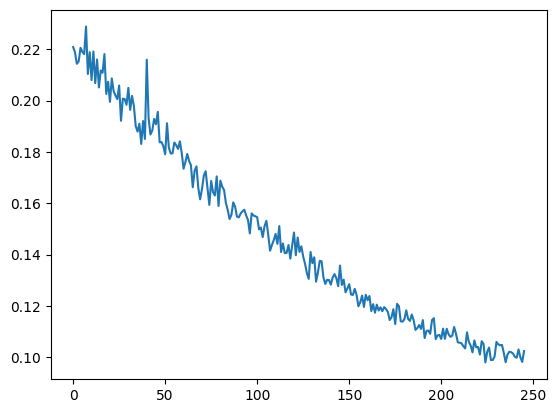

In [7]:
plt.plot(best_model['seq2seq_RNN'][2])

In [8]:
label_y, predicted, first_label_y, first_predicted = predict_mtm(best_model['seq2seq_RNN'][1], df, x_ss, y_ms, 1151, 7, 0.5, device)

93.389892578125


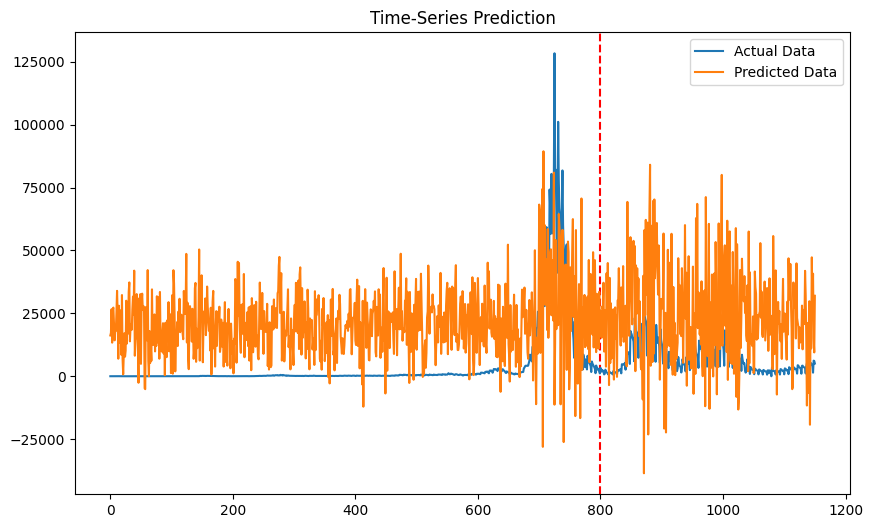

In [9]:
print(mape(label_y + 1, predicted))
plotting(first_label_y, first_predicted, 800)